## NSMC 불러와서 정제하기

* 감정분석을 위해, Naver Movie Corpus(https://github.com/e9t/nsmc/) 를 사용합니다.

In [1]:
def read_documents(filename):
    # NSMC 불러오는 함수.
    with open(filename, encoding="utf-8") as f: # 윈도우는 꼭 encoding 해줘야 함
        documents = [line.split('\t') for line in f.read().splitlines()] # f.read().splitlines()는 내용을 다 가져오는데 \n라인 형태로
                    # 데이터가 tap 기준으로 분류되어있기때문에
        documents = documents[1:] # 첫번째 줄이 카테고리 이름적혀있는 줄이라서 날려버림 (id, 등등)
        
    return documents
    
train_docs = read_documents("data/nsmc/ratings_train.txt")
test_docs = read_documents("data/nsmc/ratings_test.txt")

In [2]:
print(len(train_docs))
print(len(test_docs))

150000
50000


### 함수 정의.

In [28]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding='utf-8') as f:
        for word in f:
            SW.add(word)
            
            
    return SW

def text_tokenizing(doc):
    return [word for word in mecab.nouns(doc) if word not in SW and len(word) > 1]

### 불러온 데이터를 품사 태그를 붙여서 토크나이징합니다.

In [30]:
from konlpy.tag import Mecab
from konlpy.tag import Okt
import json
import os
import re
from pprint import pprint

# 형태소 분석기 불러오기
okt = Okt() # 혹시나 mecab 설치 실패한 분들 위해서
mecab = Mecab(dicpath="C:\\mecab\\mecab-ko-dic")

SW = define_stopwords("data/stopwords-ko.txt")

# 텍스트가 20만개이기 때문에, 정제하는데 시간이 걸린다.
# 한 번 만들고 나서는 코드를 다시 실행시켰을 때, 또 정제할 필요없이 불러오게끔 코드를 짜보자.

#  os.path.exists(): 어떤 파일이 디렉토리에 있는지 확인하는 library
if os.path.exists("train_docs.json"):
    # train_docs.json:형태소 분석기 돌려서 나온 결과를 json형태로 저장한 파일
    # 있으면 불러오기
    with open("train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
    
else:
    # 없으면 형태소 분석해야지
    # 리뷰 리스트, 레이블 가져오기
    train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])] # 리스트 형태 :id, 리뷰, lable => 탭 기준, 가운데(1번째) 해당하는 애를 넣어야해
    
    with open("train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        # ensure_ascii=False: 아스키코드 보존할거냐
        # indent='\t': 저장도 탭 기준으로
        
if os.path.exists("test_docs.json"):
    with open("test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
        
else:
    test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    
    with open("test_docs.json", "w", encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')
        
pprint(train_data[0])
pprint(test_data[0])

(['짜증', '목소리'], '0')
(['평점'], '0')


### NLTK를 이용한 histogram 분석.

* 데이터 분석을 하기 위해 기본적인 정보들을 확인합니다.

* nltk 라이브러리를 이용하여 전처리를 합니다.

In [31]:
import nltk # natural language tool kit, 한국에서 많이 쓰이진 않음

total_tokens = [token for doc in train_data for token in doc[0]]
# 왜 doc[0] -> train_data에 있는 하나하나 doc는 첫번째 리뷰, 두번째가 레이블로 만들었기때문
# 우리가 원하는 건 문장을 넣길 원해
print(len(total_tokens))

601169


In [32]:
text = nltk.Text(total_tokens, name='NMSC')
print(len(set(text.tokens))) # set(): 중복은 날려버림
pprint(text.vocab().most_common(10))

# ..은 왜 있을까
# 형태소 분석을 했기 때문에 특수문자 제거 안돼
# 특수문자 지우려면 text_cleaning함수 통해서 제거해줘야함
# 강사님은 일부러 text_cleaning함수 안 썼을 때 결과 보여주려고 안썼대

# 소셜 데이터는 함부로 한글제외 제거하면 안돼(ex. 인스타그램 댓글, ~리뷰 댓글 등)
# 영문, 숫자표현, 특수문자는 리뷰에선 의미있을 수 있어

# 그래서 결론은 보통 소셜 데이터는 cleaning하지 않고 우선 결과 봄!
# 우선 tokenizing해놓고 frequncy 통해서 특수문자나 특정 영단어가 많이 나왔다면 분석을 통해서
# 쓸모없는데 많이 나왔다던가, 의미있는 단어인지 판단한 다음에 cleaning할지 말지 정해

30917
[('영화', 57614),
 ('연기', 6835),
 ('최고', 6595),
 ('평점', 6297),
 ('스토리', 5422),
 ('드라마', 5192),
 ('생각', 5168),
 ('사람', 5035),
 ('감동', 4860),
 ('배우', 4450)]


### Histogram 그리기.

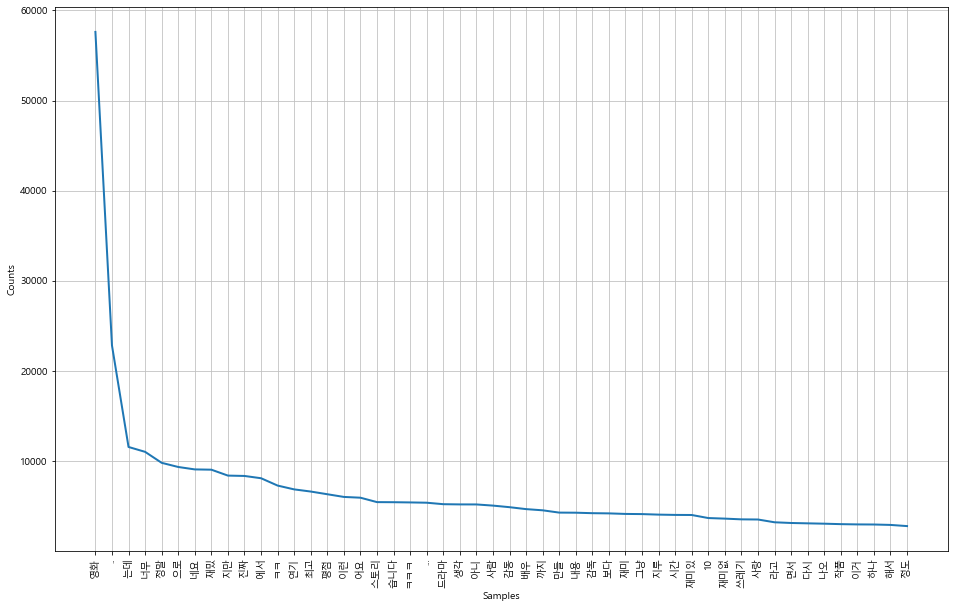

In [22]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name) 
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(16, 10))
text.plot(50)

### WordCloud 그리기.

In [24]:
# wordcloud 라이브러리를 설치합니다.
!pip install wordcloud

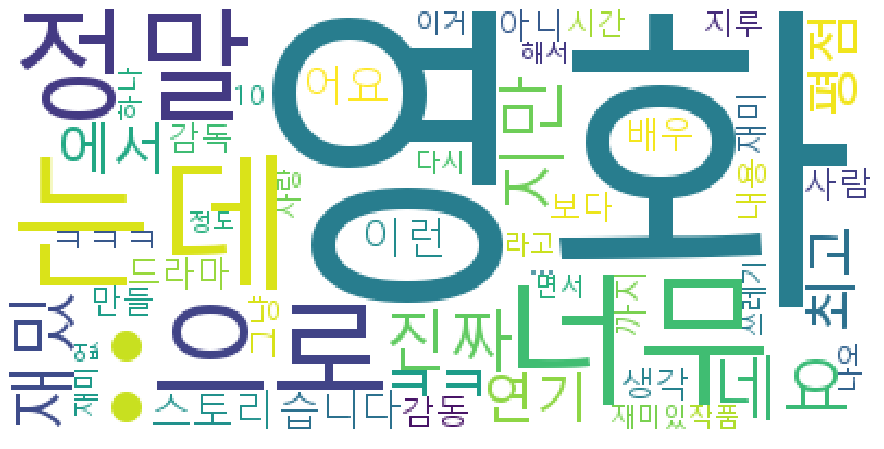

In [25]:
from wordcloud import WordCloud

data = text.vocab().most_common(50)

wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling = 0.2, # 빈도가 높은 애가 가장 크게 보여, 얘를 weight를 얼마를 주냐에 따라 상대적으로 얼마나 크게 보여지는지
                      #stopwords=STOPWORDS, # 이 단어는 안보였으면 좋겠어라는 것을 stopwords로 지정 가능
                      background_color='white',
                      ).generate_from_frequencies(dict(data)) # input 형태
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off") # matplotlib는 기본적으로 x,y축 나타내는데 워크클라우드에선 필요없으니 지워줘
plt.show()


# 보통 워드클라우드 돌릴 땐 명사 추출로 많이 함

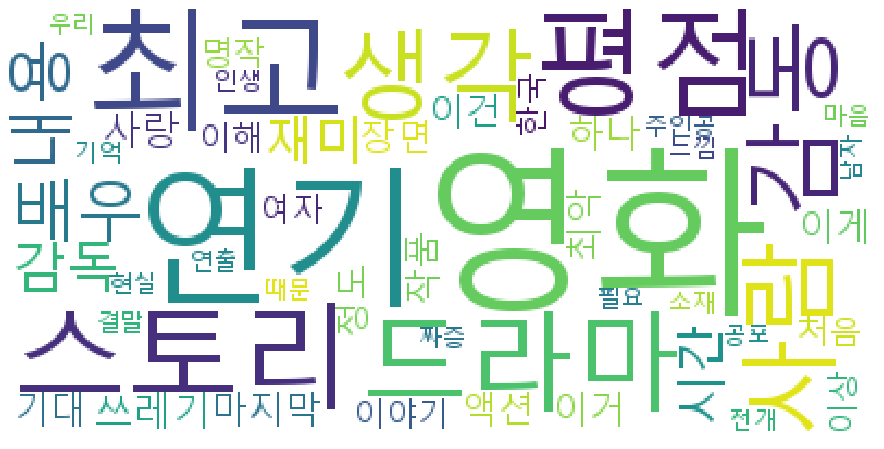

In [33]:
# 명사추출

data = text.vocab().most_common(50)

wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling = 0.2, # 빈도가 높은 애가 가장 크게 보여, 얘를 weight를 얼마를 주냐에 따라 상대적으로 얼마나 크게 보여지는지
                      #stopwords=STOPWORDS, # 이 단어는 안보였으면 좋겠어라는 것을 stopwords로 지정 가능
                      background_color='white',
                      ).generate_from_frequencies(dict(data)) # input 형태
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off") # matplotlib는 기본적으로 x,y축 나타내는데 워크클라우드에선 필요없으니 지워줘
plt.show()